# Eye classifier

The goals of this project are to build a classifier using CNN layers in a neural network in the first place, in order to classify images of eyes to figure out which one of them are opened, and which are closed, and then to create a regression to find the center of the pupil on the image. Such a tool could then be usefull in a biometric scanner, to account for human error in the handling of the scanner (blinking at the wrong time during the scan for example).

Our data is split in two folder, one containing closed eyes, and the other one containing opened eyes. Furthermore, the opened eyes folder is split in two sets, the train set and the test set, that will  come into play for thge regression task.

# Data exploration

Let's first take a look at our images.

We will create an array containing all of our images, disregarding the distinciton between train and test images (from the open folder).

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
open_imgs = []

for data_group in ['train', 'test']:
    imgs = os.listdir(f'open/{data_group}')
    for img_name in imgs:
        if img_name[-4:] == '.jpg':
            # Images come in shape (260, 400, 3), but are greyscale, so the component of shape 3 actually contains Lthe same number 3 times. So we only keep the first number.
            open_imgs.append(img_to_array(load_img(f'open/{data_group}/{img_name}'))[:,:,0:1] / 255)
open_imgs = np.array(open_imgs)

In [3]:
close_imgs = []

imgs = os.listdir('close')
for img_name in imgs:
    if img_name[-4:] == '.jpg':
        # Images come in shape (260, 400, 3), but are greyscale, so the component of shape 3 actually contains the same number 3 times. So we only keep the first number.
        close_imgs.append(img_to_array(load_img(f'close/{img_name}'))[:,:,0:1] / 255)
        
close_imgs = np.array(close_imgs)

In [4]:
all_imgs = np.concatenate([open_imgs, close_imgs])

In [5]:
# 907 images of size 260 * 400, in greyscale coded from 0 to 1.

print(all_imgs.shape)
print(all_imgs[0])

(907, 260, 400, 1)
[[[0.02352941]
  [0.00392157]
  [0.06666667]
  ...
  [0.07450981]
  [0.09411765]
  [0.08627451]]

 [[0.05882353]
  [0.08235294]
  [0.0627451 ]
  ...
  [0.09411765]
  [0.09411765]
  [0.12156863]]

 [[0.09411765]
  [0.08627451]
  [0.04705882]
  ...
  [0.06666667]
  [0.05098039]
  [0.08627451]]

 ...

 [[0.04705882]
  [0.07450981]
  [0.08627451]
  ...
  [0.07450981]
  [0.10196079]
  [0.11372549]]

 [[0.07450981]
  [0.10196079]
  [0.09019608]
  ...
  [0.14117648]
  [0.0627451 ]
  [0.06666667]]

 [[0.08627451]
  [0.04313726]
  [0.05098039]
  ...
  [0.04313726]
  [0.16862746]
  [0.07450981]]]


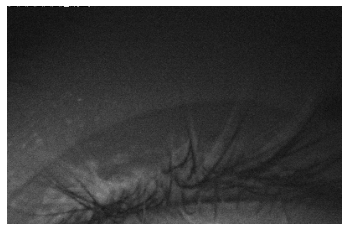

In [6]:
# This snippet shows one image randomly taken from the list of all images.

plt.imshow(all_imgs[np.random.randint(0, len(all_imgs))], cmap='gray')

plt.axis('off')
plt.show()

We have now all of our images. One important thing to notice is that the order in which they come in the array is that all opened eyes images come in first, and then all closed eyes images. This makes it very easy to create a list labelling all images as either opened eye or closed eye.

# Classification

First, we need to add labels to our images, for our classifier to have something to work on.

In [7]:
all_labels = np.array([1 for i in range(len(open_imgs))] + [0 for i in range(len(close_imgs))])

Then, we split our dataset between train and test.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=0)

We now have to create our classifier. To achieve that, we will use the LetNet5 architecture.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense

def model_clf():
    
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(260,400,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

In [10]:
model = model_clf()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 398, 6)       60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 199, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 197, 16)      880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 98, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 98784)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               11854200  
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

We can now train our network on our data.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir='./Graph_clf', histogram_freq=0, write_graph=True, write_images=True)]

In [13]:
# This snippet will remove any Graph folder preexisting
try:
    shutil.rmtree('./Graph_clf')
    print('Deleted')
except:
    pass

model.fit(x=X_train, 
          y=y_train, 
          validation_data=(X_test, y_test), 
          epochs=500, # With EarlyStopping, our training won't have to run this many epochs
          batch_size=64, 
          callbacks=callbacks)

Epoch 1/500
 1/12 [=>............................] - ETA: 0s - loss: 0.6876 - accuracy: 0.6719WARNING:tensorflow:From /home/romaincaplier/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 1s 70ms/step - loss: 2.7543 - accuracy: 0.5421 - val_loss: 0.5810 - val_accuracy: 0.7308
Epoch 2/500
12/12 [==============================] - 0s 38ms/step - loss: 0.5783 - accuracy: 0.7324 - val_loss: 0.4390 - val_accuracy: 0.8242
Epoch 3/500
12/12 [==============================] - 0s 38ms/step - loss: 0.4465 - accuracy: 0.8014 - val_loss: 0.3760 - val_accuracy: 0.8516
Epoch 4/500
12/12 [==============================] - 0s 38ms/step - loss: 0.3841 - accuracy: 0.8414 - val_loss: 0.3495 - val_accuracy: 0.8571
Epoch 5/500
12/12 [========

In [14]:
%load_ext tensorboard
%tensorboard --logdir Graph_clf

Reusing TensorBoard on port 6007 (pid 25015), started 0:28:18 ago. (Use '!kill 25015' to kill it.)

Let's now look at the performances of our model, by computing the prediction.

In [15]:
y_pred = np.rint(model.predict(X_test, batch_size=64, verbose=1)).astype('int').flatten()

3/3 [==============================] - 0s 10ms/step


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.99      0.99      0.99       116

    accuracy                           0.99       182
   macro avg       0.99      0.99      0.99       182
weighted avg       0.99      0.99      0.99       182



Our model gives us 98% accuracy, and 98% f1, which is a good result.

Theses number could be improved by tweaking the model.

# Regression

We now only consider images of opened eyes (as finding the center of the pupil is quite impossible when the pupil isn't even on the image). These images are split in two sets, one training set and one testing set. These two folder also contain one csv each, which gives us the position of the center of the pupil. As it is what we are trying to predict, we will first load them in dataframes.

In [17]:
import pandas as pd

centers_train = pd.read_csv('open/train/dataPupilCenterTrain.csv').drop('id', axis=1)
centers_test = pd.read_csv('open/test/dataPupilCenterTest.csv').drop('id', axis=1)

In [18]:
centers_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   xcentral  480 non-null    object
 1   ycentral  480 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [19]:
centers_train['xcentral'].value_counts()

?      49
216     6
225     6
138     6
259     6
       ..
242     1
126     1
175     1
353     1
229     1
Name: xcentral, Length: 195, dtype: int64

We can see here that there are a lines where the center position isn't given. We cannot use the corresponding images, so we will have to purge them from our dataset. 

We will remove every image that has at least one unknown center coordinate (even in our testing set, because these centers need to be known to be able to evaluate the performance of our model).

In [20]:
# We create the list of id of the bad images.

bad_train_imgs_ids = centers_train.loc[~ centers_train['xcentral'].str.isnumeric() | ~ centers_train['ycentral'].str.isnumeric()].index
bad_test_imgs_ids = centers_test.loc[~ centers_test['xcentral'].str.isnumeric() | ~ centers_test['ycentral'].str.isnumeric()].index

In [21]:
# We drop all corresponding images

centers_train.drop(bad_train_imgs_ids, axis=0, inplace=True)
centers_test.drop(bad_test_imgs_ids, axis=0, inplace=True)

In [22]:
# We convert all strings into numbers

centers_train = centers_train.astype('int')
centers_test = centers_test.astype('int')

Now that we know which images we can keep, we can build our two new image arrays.

In [23]:
train_imgs = []

imgs = os.listdir('open/train')
for img_name in imgs:
    if img_name[-4:] == '.jpg' and int(''.join([c for c in img_name if c.isdigit()])) not in bad_train_imgs_ids:
        index = int(''.join([c for c in img_name if c.isdigit()]))
        # Images come in shape (260, 400, 3), but are greyscale, so the component of shape 3 actually contains Lthe same number 3 times. So we only keep the first number.à
        train_imgs.append([index, img_to_array(load_img(f'open/train/{img_name}'))[:,:,0:1] / 255])

train_imgs = np.stack(np.array(sorted(np.array(train_imgs), key=lambda img: img[0]))[:,1], axis=0)

In [24]:
test_imgs = []

imgs = os.listdir('open/test')
for img_name in imgs:
    if img_name[-4:] == '.jpg' and int(''.join([c for c in img_name if c.isdigit()])) not in bad_test_imgs_ids:
        index = int(''.join([c for c in img_name if c.isdigit()]))
        # Images come in shape (260, 400, 3), but are greyscale, so the component of shape 3 actually contains Lthe same number 3 times. So we only keep the first number.à
        test_imgs.append([index, img_to_array(load_img(f'open/test/{img_name}'))[:,:,0:1] / 255])

test_imgs = np.stack(np.array(sorted(np.array(test_imgs), key=lambda img: img[0]))[:,1], axis=0)

We can now build our model. Here, we will still use the same basic architecture as used above.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense
from tensorflow.keras import regularizers

def model_reg(regul=0.00):
    
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(260,400,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(regul)))
    model.add(Dense(units=84, activation='relu', kernel_regularizer=regularizers.l2(regul)))
    
    model.add(Dense(units=2, activation='linear'))
    
    return model

In [26]:
model = model_reg(0.01)
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 258, 398, 6)       60        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 129, 199, 6)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 197, 16)      880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 98, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 98784)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               11854200  
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

callbacks = [EarlyStopping(monitor='val_loss', patience=30),
             TensorBoard(log_dir='./Graph_reg', histogram_freq=0, write_graph=True, write_images=True)]

In [29]:
# This snippet will remove any Graph folder preexisting
try:
    shutil.rmtree('./Graph_reg')
    print('Deleted')
except:
    pass

model.fit(x=train_imgs, 
          y=centers_train.values, 
          validation_data=(test_imgs, centers_test.values), 
          epochs=200,
          batch_size=64, 
          callbacks=callbacks)

Epoch 1/200
7/7 [==============================] - 1s 103ms/step - loss: 33233.3008 - val_loss: 13348.0781
Epoch 2/200
7/7 [==============================] - 0s 40ms/step - loss: 11449.5205 - val_loss: 18680.4512
Epoch 3/200
7/7 [==============================] - 0s 38ms/step - loss: 7210.0083 - val_loss: 5691.1528
Epoch 4/200
7/7 [==============================] - 0s 39ms/step - loss: 5958.1143 - val_loss: 4882.1006
Epoch 5/200
7/7 [==============================] - 0s 38ms/step - loss: 4606.9609 - val_loss: 7381.7290
Epoch 6/200
7/7 [==============================] - 0s 39ms/step - loss: 4175.7944 - val_loss: 4081.7043
Epoch 7/200
7/7 [==============================] - 0s 38ms/step - loss: 3609.8748 - val_loss: 4894.3799
Epoch 8/200
7/7 [==============================] - 0s 40ms/step - loss: 3116.3528 - val_loss: 3751.9187
Epoch 9/200
7/7 [==============================] - 0s 38ms/step - loss: 2706.4985 - val_loss: 3707.4663
Epoch 10/200
7/7 [==============================] - 0s 38ms

In [30]:
%load_ext tensorboard
%tensorboard --logdir Graph_reg

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 25051), started 0:28:28 ago. (Use '!kill 25051' to kill it.)

We see here that our model is overfitting vastly. Let's look at the predicted result, first on our train dataset, and then on our test dataset

In [31]:
y_pred_train = model.predict(train_imgs)

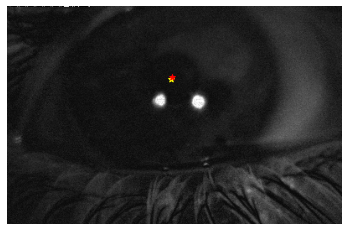

In [39]:
# Display the results for some eyes
index = np.random.randint(0, len(train_imgs))

# Image to display
display = train_imgs[index]
center_pred = y_pred_train[index]
center_true = centers_train.values[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
point_pred = plt.scatter(center_pred[0], center_pred[1], marker='*', c='yellow')
point_true = plt.scatter(center_true[0], center_true[1], marker='*', c='red')

# Add the patch to the Axes
plt.axis('off')
plt.show()

In [33]:
y_pred_test = model.predict(test_imgs)

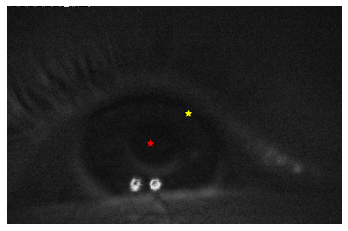

In [36]:
# Display the results for some eyes
index = np.random.randint(0, len(test_imgs))

# Image to display
display = test_imgs[index]
center_pred = y_pred_test[index]
center_true = centers_test.values[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
point_pred = plt.scatter(center_pred[0], center_pred[1], marker='*', c='yellow')
point_true = plt.scatter(center_true[0], center_true[1], marker='*', c='red')

# Add the patch to the Axes
plt.axis('off')
plt.show()

As we can see, even if the train daataset provides us with reasonably good results, the performance on our test dataset is pretty poor.

To improve this projet, overfitting should be the focus. To reduce it, adding regularization, or improving the model would help out a lot.